In [1]:
import time
import numpy as np
import pandas as pd

In [2]:
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Layer
import tensorflow as tf
import dan_models
import dan_utils

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
class_set = [2, 3, 4]
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res=11, randseed=25)

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [34]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i = 2

near_road = np.array(near_road_set[class_i])
flow = v_class[class_i].iloc[:, 2:-1]

prop = 0.8  # proportion of training data
from_day = 1
to_day = 24
num_links = v_class[class_i].shape[0]

image_train, image_test, day_train, day_test, label_train, label_test\
= dan_utils.sliding_window(
    flow, near_road, from_day, to_day, prop, num_links
)

t_input = image_train.shape[2]
t_pre = label_train.shape[2]
k = image_train.shape[1]

(2772, 5, 12, 40)
(2217, 5, 12, 40)
(555, 5, 12, 40)
(2217, 40, 6)
(555, 40, 6)


In [35]:
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 40)]  0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 5, 12, 40)    160         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 5, 12, 40)    14440       batch_normalization_6[0][0]      
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 5, 12, 40)    0           conv2d_4[0][0]                   
____________________________________________________________________________________________

In [36]:
finish_model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
X_train = image_train
X_HA_train = day_train
label_train = label_train

In [38]:
#模型拟合与评估
finish_model.fit([X_train,X_HA_train], label_train, epochs=700, batch_size=2048,
validation_data=([image_test,day_test], label_test))
# finish_model.evaluate(image_test, label_test)

Epoch 1/700
2/2 [==============================] - 1s 144ms/step - loss: 263445.3750 - val_loss: 269765.6875
Epoch 2/700
2/2 [==============================] - 0s 37ms/step - loss: 262035.1198 - val_loss: 268517.0938
Epoch 3/700
2/2 [==============================] - 0s 54ms/step - loss: 261592.2604 - val_loss: 267081.2812
Epoch 4/700
2/2 [==============================] - 0s 49ms/step - loss: 260292.3333 - val_loss: 265337.1875
Epoch 5/700
2/2 [==============================] - 0s 38ms/step - loss: 258864.0885 - val_loss: 263146.5625
Epoch 6/700
2/2 [==============================] - 0s 38ms/step - loss: 257926.0625 - val_loss: 260345.0781
Epoch 7/700
2/2 [==============================] - 0s 39ms/step - loss: 256253.2552 - val_loss: 256766.0625
Epoch 8/700
2/2 [==============================] - 0s 37ms/step - loss: 254859.7188 - val_loss: 252374.6250
Epoch 9/700
2/2 [==============================] - 0s 39ms/step - loss: 253141.1979 - val_loss: 247036.3750
Epoch 10/700
2/2 [=========

2/2 [==============================] - 0s 37ms/step - loss: 98407.8516 - val_loss: 110985.3672
Epoch 77/700
2/2 [==============================] - 0s 35ms/step - loss: 97832.2318 - val_loss: 110978.7891
Epoch 78/700
2/2 [==============================] - 0s 47ms/step - loss: 97339.2656 - val_loss: 110487.7812
Epoch 79/700
2/2 [==============================] - 0s 44ms/step - loss: 96973.4922 - val_loss: 113178.7656
Epoch 80/700
2/2 [==============================] - 0s 44ms/step - loss: 96389.1328 - val_loss: 117677.4766
Epoch 81/700
2/2 [==============================] - 0s 36ms/step - loss: 96283.0339 - val_loss: 116223.5469
Epoch 82/700
2/2 [==============================] - 0s 36ms/step - loss: 95672.1042 - val_loss: 112064.9375
Epoch 83/700
2/2 [==============================] - 0s 36ms/step - loss: 94696.0651 - val_loss: 109109.5391
Epoch 84/700
2/2 [==============================] - 0s 35ms/step - loss: 94325.1250 - val_loss: 108581.2266
Epoch 85/700
2/2 [=======================

2/2 [==============================] - 0s 43ms/step - loss: 69065.3177 - val_loss: 75273.1406
Epoch 153/700
2/2 [==============================] - 0s 40ms/step - loss: 68599.6641 - val_loss: 73457.1562
Epoch 154/700
2/2 [==============================] - 0s 39ms/step - loss: 68164.4792 - val_loss: 72628.4062
Epoch 155/700
2/2 [==============================] - 0s 42ms/step - loss: 68038.7630 - val_loss: 72685.2344
Epoch 156/700
2/2 [==============================] - 0s 42ms/step - loss: 67752.1875 - val_loss: 72468.3906
Epoch 157/700
2/2 [==============================] - 0s 45ms/step - loss: 67417.4635 - val_loss: 71627.8281
Epoch 158/700
2/2 [==============================] - 0s 41ms/step - loss: 67020.6771 - val_loss: 70818.0078
Epoch 159/700
2/2 [==============================] - 0s 50ms/step - loss: 66754.1745 - val_loss: 70266.4141
Epoch 160/700
2/2 [==============================] - 0s 41ms/step - loss: 66505.5781 - val_loss: 69940.4453
Epoch 161/700
2/2 [=======================

Epoch 228/700
2/2 [==============================] - 0s 36ms/step - loss: 48615.9974 - val_loss: 53850.2695
Epoch 229/700
2/2 [==============================] - 0s 37ms/step - loss: 48403.4167 - val_loss: 53086.4727
Epoch 230/700
2/2 [==============================] - 0s 36ms/step - loss: 48080.6016 - val_loss: 51909.4961
Epoch 231/700
2/2 [==============================] - 0s 44ms/step - loss: 47904.2396 - val_loss: 51088.7109
Epoch 232/700
2/2 [==============================] - 0s 45ms/step - loss: 47705.9492 - val_loss: 50536.7188
Epoch 233/700
2/2 [==============================] - 0s 36ms/step - loss: 47529.6003 - val_loss: 50134.2148
Epoch 234/700
2/2 [==============================] - 0s 47ms/step - loss: 47366.6549 - val_loss: 50047.6992
Epoch 235/700
2/2 [==============================] - 0s 36ms/step - loss: 47224.2188 - val_loss: 49742.2070
Epoch 236/700
2/2 [==============================] - 0s 36ms/step - loss: 46908.4870 - val_loss: 49568.2031
Epoch 237/700
2/2 [=========

Epoch 304/700
2/2 [==============================] - 0s 36ms/step - loss: 33308.5664 - val_loss: 36063.4531
Epoch 305/700
2/2 [==============================] - 0s 45ms/step - loss: 33163.2044 - val_loss: 35663.3789
Epoch 306/700
2/2 [==============================] - 0s 45ms/step - loss: 32966.2734 - val_loss: 35448.2148
Epoch 307/700
2/2 [==============================] - 0s 37ms/step - loss: 32764.3535 - val_loss: 35521.8750
Epoch 308/700
2/2 [==============================] - 0s 37ms/step - loss: 32546.3633 - val_loss: 35853.2930
Epoch 309/700
2/2 [==============================] - 0s 36ms/step - loss: 32433.1322 - val_loss: 35883.2773
Epoch 310/700
2/2 [==============================] - 0s 37ms/step - loss: 32316.1745 - val_loss: 35310.0000
Epoch 311/700
2/2 [==============================] - 0s 37ms/step - loss: 32051.4173 - val_loss: 34823.0508
Epoch 312/700
2/2 [==============================] - 0s 39ms/step - loss: 31956.4453 - val_loss: 34714.2422
Epoch 313/700
2/2 [=========

Epoch 380/700
2/2 [==============================] - 0s 36ms/step - loss: 22934.1237 - val_loss: 25299.4043
Epoch 381/700
2/2 [==============================] - 0s 37ms/step - loss: 22765.4479 - val_loss: 25082.7617
Epoch 382/700
2/2 [==============================] - 0s 39ms/step - loss: 22745.5924 - val_loss: 24757.4004
Epoch 383/700
2/2 [==============================] - 0s 38ms/step - loss: 22575.5990 - val_loss: 24282.0098
Epoch 384/700
2/2 [==============================] - 0s 38ms/step - loss: 22461.5645 - val_loss: 24050.5840
Epoch 385/700
2/2 [==============================] - 0s 48ms/step - loss: 22392.9961 - val_loss: 23916.6562
Epoch 386/700
2/2 [==============================] - 0s 38ms/step - loss: 22295.9824 - val_loss: 23840.2734
Epoch 387/700
2/2 [==============================] - 0s 39ms/step - loss: 22127.9616 - val_loss: 24022.3418
Epoch 388/700
2/2 [==============================] - 0s 38ms/step - loss: 21984.0951 - val_loss: 24255.7402
Epoch 389/700
2/2 [=========

Epoch 456/700
2/2 [==============================] - 0s 37ms/step - loss: 15873.4297 - val_loss: 17319.6309
Epoch 457/700
2/2 [==============================] - 0s 36ms/step - loss: 15805.5537 - val_loss: 17220.8965
Epoch 458/700
2/2 [==============================] - 0s 37ms/step - loss: 15696.2493 - val_loss: 17328.2266
Epoch 459/700
2/2 [==============================] - 0s 36ms/step - loss: 15638.7962 - val_loss: 17184.1094
Epoch 460/700
2/2 [==============================] - 0s 37ms/step - loss: 15618.6257 - val_loss: 16979.2852
Epoch 461/700
2/2 [==============================] - 0s 37ms/step - loss: 15499.0840 - val_loss: 16900.5332
Epoch 462/700
2/2 [==============================] - 0s 36ms/step - loss: 15470.6989 - val_loss: 16823.8047
Epoch 463/700
2/2 [==============================] - 0s 37ms/step - loss: 15376.8802 - val_loss: 16724.5977
Epoch 464/700
2/2 [==============================] - 0s 36ms/step - loss: 15286.4974 - val_loss: 16661.1250
Epoch 465/700
2/2 [=========

Epoch 532/700
2/2 [==============================] - 0s 40ms/step - loss: 11456.2272 - val_loss: 12928.4600
Epoch 533/700
2/2 [==============================] - 0s 49ms/step - loss: 11350.8262 - val_loss: 12723.2832
Epoch 534/700
2/2 [==============================] - 0s 37ms/step - loss: 11235.8470 - val_loss: 12700.3994
Epoch 535/700
2/2 [==============================] - 0s 38ms/step - loss: 11208.5199 - val_loss: 12498.3379
Epoch 536/700
2/2 [==============================] - 0s 38ms/step - loss: 11131.1582 - val_loss: 12462.1582
Epoch 537/700
2/2 [==============================] - 0s 37ms/step - loss: 11147.2461 - val_loss: 12660.2402
Epoch 538/700
2/2 [==============================] - 0s 45ms/step - loss: 11085.2773 - val_loss: 12858.0811
Epoch 539/700
2/2 [==============================] - 0s 38ms/step - loss: 11031.2826 - val_loss: 12551.8613
Epoch 540/700
2/2 [==============================] - 0s 38ms/step - loss: 10918.5260 - val_loss: 12622.9160
Epoch 541/700
2/2 [=========

2/2 [==============================] - 0s 36ms/step - loss: 8396.0332 - val_loss: 9948.7236
Epoch 609/700
2/2 [==============================] - 0s 36ms/step - loss: 8420.5557 - val_loss: 9768.0449
Epoch 610/700
2/2 [==============================] - 0s 36ms/step - loss: 8377.8444 - val_loss: 9694.8701
Epoch 611/700
2/2 [==============================] - 0s 47ms/step - loss: 8325.5469 - val_loss: 9619.2607
Epoch 612/700
2/2 [==============================] - 0s 37ms/step - loss: 8287.4681 - val_loss: 9703.3271
Epoch 613/700
2/2 [==============================] - 0s 37ms/step - loss: 8258.5983 - val_loss: 9617.7861
Epoch 614/700
2/2 [==============================] - 0s 36ms/step - loss: 8233.0638 - val_loss: 9458.2822
Epoch 615/700
2/2 [==============================] - 0s 45ms/step - loss: 8213.7223 - val_loss: 9340.2773
Epoch 616/700
2/2 [==============================] - 0s 37ms/step - loss: 8202.0319 - val_loss: 9368.5957
Epoch 617/700
2/2 [==============================] - 0s 37ms

2/2 [==============================] - 0s 41ms/step - loss: 6739.9468 - val_loss: 8133.7749
Epoch 686/700
2/2 [==============================] - 0s 38ms/step - loss: 6726.0996 - val_loss: 8071.7109
Epoch 687/700
2/2 [==============================] - 0s 37ms/step - loss: 6677.1756 - val_loss: 8104.5073
Epoch 688/700
2/2 [==============================] - 0s 37ms/step - loss: 6703.8174 - val_loss: 7872.2173
Epoch 689/700
2/2 [==============================] - 0s 46ms/step - loss: 6634.8410 - val_loss: 7990.1250
Epoch 690/700
2/2 [==============================] - 0s 45ms/step - loss: 6657.9258 - val_loss: 7919.9497
Epoch 691/700
2/2 [==============================] - 0s 36ms/step - loss: 6633.0588 - val_loss: 7941.3335
Epoch 692/700
2/2 [==============================] - 0s 37ms/step - loss: 6696.6406 - val_loss: 7902.7827
Epoch 693/700
2/2 [==============================] - 0s 37ms/step - loss: 6721.2907 - val_loss: 7837.5737
Epoch 694/700
2/2 [==============================] - 0s 37ms

In [39]:
#模型预测
model_pre = finish_model.predict([image_test,day_test])

In [40]:
#计算各项误差指标

m = 5
nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.08624374616856381
mape = 0.19304432073718455
smape = 0.1720969472344335
mae = 64.45001497309738


In [33]:
#模型保存
finish_model.save_weights('../model/base_ST-DTNN_%s_mape=%.5f_nrmse=%.5f.h5'%(class_color_set[class_i], mape_mean, nrmse_mean))
# finish_model.save_weights('../model/source_%s.h5'%(class_color_set[class_i]))

In [17]:
#计算每条路段的误差
mape_list = []
for i in range(num_links):
    a1 = dan_utils.mape_loss_func(model_pre[:,i,:], label_test[:,i,:], m)
    mape_list.append(a1)
    print(str(i+1)+'th link')
    print(a1)

1th link
0.09650608776484285
2th link
0.1303678822402378
3th link
0.28626039006487897
4th link
0.17745146811609544
5th link
0.04330767776721145
6th link
0.11752884724376596
7th link
0.30882876256543035
8th link
0.12756640474372033
9th link
0.3002468795161753
10th link
0.8774705158738798
11th link
0.10127761312294192
12th link
0.15681071440177485
13th link
0.14786896474937664
14th link
0.12036382354149393
15th link
0.2881563365141448
16th link
0.1953547265215136
17th link
0.18183772635994164
18th link
0.32703088686860915
19th link
0.18930974204224232
20th link
0.099947373184862
21th link
0.15228874679489712
22th link
0.10550804663226387
23th link
0.16395161588693635
24th link
0.10352271935807861
25th link
0.09023076296273955
26th link
0.11919193839432293
27th link
0.09162481469965568
28th link
0.10003356723384968
29th link
0.12577086439059515
30th link
0.19590004214184933
31th link
0.136206741736497
32th link
0.09246396259906085
33th link
0.648084402876048
34th link
0.18013711087041837


In [18]:
mape_pd = pd.Series(mape_list)

In [19]:
mape_pd.sort_values()

4     0.043308
24    0.090231
26    0.091625
31    0.092464
37    0.095629
0     0.096506
39    0.098011
19    0.099947
27    0.100034
10    0.101278
23    0.103523
21    0.105508
35    0.109634
38    0.115361
5     0.117529
25    0.119192
13    0.120364
28    0.125771
7     0.127566
1     0.130368
30    0.136207
12    0.147869
34    0.149056
36    0.151457
20    0.152289
11    0.156811
22    0.163952
3     0.177451
33    0.180137
16    0.181838
18    0.189310
15    0.195355
29    0.195900
2     0.286260
14    0.288156
8     0.300247
6     0.308829
17    0.327031
32    0.648084
9     0.877471
dtype: float64

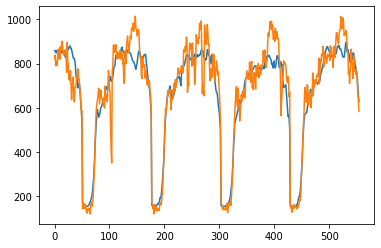

In [20]:
import matplotlib.pyplot as plt

plt.plot(model_pre[:, 0, 0])
plt.plot(label_test[:, 0, 0])

In [25]:
model_pre.shape

(555, 40, 6)